# Dangours Farm Insects CNN Classifier 


## Installing and Loading Required Libraries

In [213]:
!pip install pytorch_lightning
!pip install pytorch
!pip install numpy
!pip install pandas
!pip install matplotlib

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pytorch


  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 251, in build_wheel
          return _build_backend().build_wheel(wheel_directory, config_settings,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\Dominic\AppData\Local\Temp

In [214]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

## Preprocessing Data

### Obtaining Classifications

In [215]:
dir0='./farm_insects'
class_names=sorted(os.listdir(dir0)) 
print(class_names)

['Africanized Honey Bees (Killer Bees)', 'Aphids', 'Armyworms', 'Brown Marmorated Stink Bugs', 'Cabbage Loopers', 'Citrus Canker', 'Colorado Potato Beetles', 'Corn Borers', 'Corn Earworms', 'Fall Armyworms', 'Fruit Flies', 'Spider Mites', 'Thrips', 'Tomato Hornworms', 'Western Corn Rootworms']


### Specifying Transformations

In [216]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

### Creating Data Modules

In [217]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32, num_workers=32):
        super().__init__()
        self.root_dir = "./farm_insects"
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset


### Creating CNN Model

In [218]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.004)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

## Training Model

In [219]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=30)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 315   
---------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.448    Total estimated model params size (MB)
d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wo

Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s] 

Epoch 0:  15%|█▌        | 6/40 [00:04<00:27,  1.24it/s, v_num=7]

d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 29: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s, v_num=7]

d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at d:\Projects\dangerous-farm-bugs\lightning_logs\version_7\checkpoints\epoch=29-step=1200.ckpt
Loaded model weights from the checkpoint at d:\Projects\dangerous-farm-bugs\lightning_logs\version_7\checkpoints\epoch=29-step=1200.ckpt
d:\Projects\dangerous-farm-bugs\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.49367088079452515
        test_loss           1.5930112600326538
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Evaluating Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


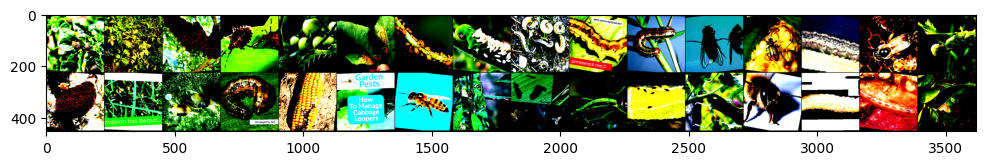

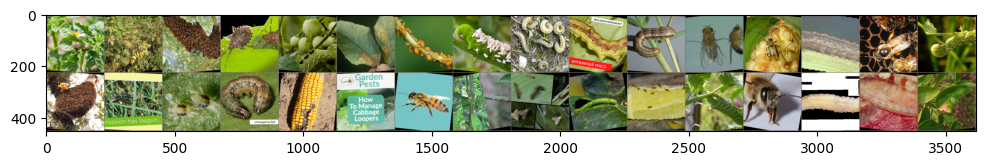

In [220]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [221]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)     0.3684    0.7000    0.4828        20
                              Aphids     0.7857    0.5789    0.6667        19
                           Armyworms     0.2258    0.4667    0.3043        15
         Brown Marmorated Stink Bugs     0.7222    0.5652    0.6341        23
                     Cabbage Loopers     0.6296    0.7083    0.6667        24
                       Citrus Canker     0.7059    0.5714    0.6316        21
             Colorado Potato Beetles     0.7692    0.5556    0.6452        18
                         Corn Borers     0.5714    0.5455    0.5581        22
                       Corn Earworms     0.3023    0.5417    0.3881        24
                      Fall Armyworms     0.3684    0.3333    0.3500        21
                         Fruit Flies     0.8421    0.6957    0.7619        23
                        Spider Mites     0.8000    0.5217    0.

## Saving the Model

In [222]:
torch.save(model.state_dict(), 'scary_bugs_classification.pth') # Saves to the root directory


# Uncomment the line below to save the model to the application 
# torch.save(model.state_dict(), './app/backend/scary_bugs_classification.pth') 


## Prediction Functions  

In [223]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('scary_bugs_classification.pth'))
model.eval()

# Function to predict the class of the bug
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted[0].item()]
    
    return predicted_class

# Predict the class of the bug
predict_image('./farm_insects/Aphids/Image_1.jpeg')

'Aphids'

100%|██████████| 1000/1000 [00:03<00:00, 283.24it/s]


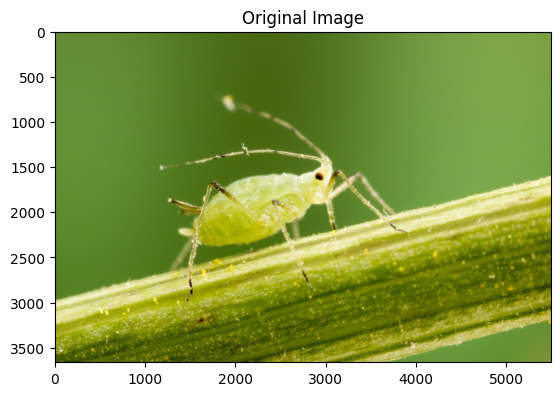

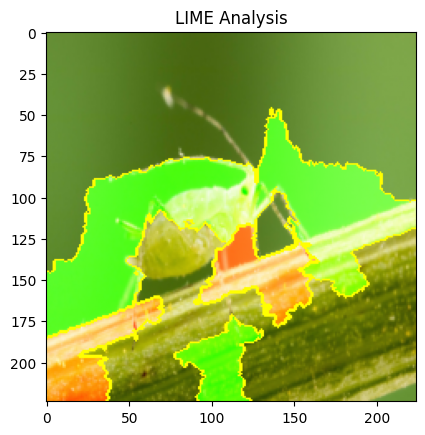

In [237]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    
    return transf

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    
    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    
    return transf    

pill_transf = get_pil_transform()

preprocess_transform = get_preprocess_transform()


# Define function for batch prediction
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cpu")   #"cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

img_path = './farm_insects/Aphids/Image_1.jpeg'
img = get_image(img_path)

# Create explanation using Lime
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, 
                                         top_labels=len(class_names), 
                                         hide_color=0, 
                                         num_samples=1000) 

# Visualize Lime explanation
plt.imshow(img)
plt.title("Original Image")
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.title("LIME Analysis")
plt.imshow(img_boundry)
plt.show()